# Gemcitabine ALL Samples

In [ ]:
# Set the working directory for DNA_REPi Gemcitabine ALL analysis
source('../../functions.R')
setwd('../../DNA_REPi/Gemcitabine/Expression_Mutation_CNA')

In [2]:
#---------------------------------------------------------------------------------------------------------------
# Read and process sensitive and resistant samples for DNA_REPi Gemcitabine ALL data (expression, mutation, CNA)

# Process the input data files for sensitive and resistant samples
DNAi_Gemcitabine_ALL = process_drug_data(
        expr_sensitive_file = 'TCGA - EMC DNA_REPi Gemcitabine Sensitive Samples Gene Expression.tsv',
        cna_sensitive_file = 'TCGA - EMC DNA_REPi Gemcitabine Sensitive Samples CNA.tsv',
        expr_resistant_file = 'TCGA - EMC DNA_REPi Gemcitabine Resistant Samples Gene Expression.tsv',
        cna_resistant_file = 'TCGA - EMC DNA_REPi Gemcitabine Resistant Samples CNA.tsv',
        mut_sensitive_file = 'TCGA - EMC DNA_REPi Gemcitabine Sensitive Samples Mutation.tsv',
        mut_resistant_file = 'TCGA - EMC DNA_REPi Gemcitabine Resistant Samples Mutation.tsv'
)

# Assign condition factor levels (sensitive and resistant)
DNAi_Gemcitabine_ALL$condition = factor(DNAi_Gemcitabine_ALL$condition, levels = c('resistant','sensitive'))

#---------------------------------------------------------------------------------------------------------------
# Clinical Data Processing

# Retrieve clinical data for multiple TCGA projects
DNAi_ALL_Clinical = get_multiple_clinical_data(tcga_project = c('TCGA-PAAD', 'TCGA-PCPG', 'TCGA-LIHC', 'TCGA-LUSC', 'TCGA-SARC'))

# Check the overlap between processed data and clinical data
sum(rownames(DNAi_Gemcitabine_ALL) %in% DNAi_ALL_Clinical$submitter_id) # 55 samples

# Filter clinical data to retain only matching samples
DNAi_ALL_Clinical_Gemcitabine = DNAi_ALL_Clinical %>% filter(submitter_id %in% rownames(DNAi_Gemcitabine_ALL))

new_row_indices <- match(rownames(DNAi_Gemcitabine_ALL), DNAi_ALL_Clinical_Gemcitabine$submitter_id)
DNAi_ALL_Clinical_Gemcitabine <- DNAi_ALL_Clinical_Gemcitabine[new_row_indices, ]

# Create a survival object using clinical data
DNAi_ALL_Gemcitabine_Surv = Surv(
        time = DNAi_ALL_Clinical_Gemcitabine$overall_survival,
        event = DNAi_ALL_Clinical_Gemcitabine$deceased
)
#saveRDS(DNAi_ALL_Gemcitabine_Surv, 'Results/DNAi_ALL_Gemcitabine_Surv.rds')
#DNAi_ALL_Gemcitabine_Surv = readRDS('Results/DNAi_ALL_Gemcitabine_Surv.rds')


[1] 55

In [ ]:
dir.create('Results',showWarnings = FALSE)
dir.create('Graphs',showWarnings = FALSE)

### Note on Computation Time
The calculation steps for the Penalized Cox Models and the subsequent Multi-Gene Cox Models are computationally intensive and can take a significant amount of time to run.

For your convenience, you can skip re-running these analyses. The code block below allows you to directly load the pre-computed results (.rds files) to proceed with the analysis and visualization steps immediately

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Penalized Cox Regression Analysis

# Run penalized Cox regression model for Gemcitabine ALL
DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel = drug_small_sample_models_cond_penalized_with_pvalue_optimized(
        data = DNAi_Gemcitabine_ALL,
        surv_obj = DNAi_ALL_Gemcitabine_Surv,
        seed = 73
)

# Load enriched terms and extract unique genes for pathway analysis
enrich_terms = read_excel('enriched_terms.xlsx')
gen_list <- extract_unique_genes(enrich_terms)

# Process the existing models with the extracted gene list
DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel <- process_models(DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel, gen_list)

# Save the processed Cox models
#saveRDS(DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel, 'Results/DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel.rds')


In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Multi-Gene Cox Models

# Run multi-gene Cox models without combination terms
multiGeneCox_DNAi_ALL = drug_multigene_models_cond_penalized(
        DNAi_Gemcitabine_ALL,
        DNAi_ALL_Gemcitabine_Surv,
        pathway_file = 'enriched_terms.xlsx',
        DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel,
        combination = F,
        seed = 73
)

# Save multi-gene Cox model results
#saveRDS(multiGeneCox_DNAi_ALL, 'Results/DNAi_EMC_ALL_Gemcitabine_MultiGeneCox.rds')

### Load Pre-Computed Results

To skip the lengthy model computation steps, simply run the following code block. This will load the pre-calculated models (`DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel` and `multiGeneCox_DNAi_ALL`) directly from their saved `.rds` files.

In [3]:
#LOAD
DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel = readRDS('Results/DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel.rds')
multiGeneCox_DNAi_ALL = readRDS('Results/DNAi_EMC_ALL_Gemcitabine_MultiGeneCox.rds')

#---------------------------------------------------------------------------------------------------------------

Processing genes for cna 
Filtered gene list for cna : MGST2, CDH1, BMP4, GPX8 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


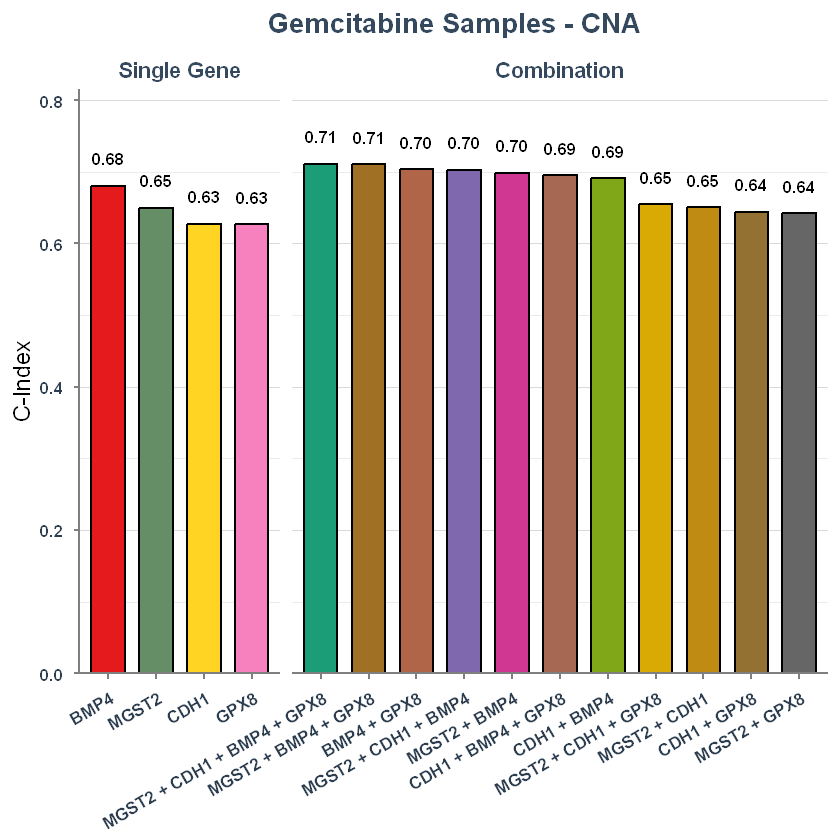

In [5]:
#---------------------------------------------------------------------------------------------------------------
# Gene Combination Analysis

results_MGST2_CDH1_BMP4_GPX8 = analyze_genes_for_combinations(
  gene_list = c("MGST2", "CDH1", "BMP4", "GPX8"),
  processed_data = DNAi_Gemcitabine_ALL,
  surv_obj = DNAi_ALL_Gemcitabine_Surv,
  single_gene_model = DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel,
  seed = 73
)

# Generate and save C-index barplots for gene combinations
results_MGST2_CDH1_BMP4_GPX8_plot = plot_cindex_results_separate(results_MGST2_CDH1_BMP4_GPX8, 'Gemcitabine Samples')
results_MGST2_CDH1_BMP4_GPX8_plot
#saveRDS(results_MGST2_CDH1_BMP4_GPX8_plot$CNA, 'Graphs/MGST2_CDH1_BMP4_GPX8_ALL_Cindex.rds')


In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Kaplan-Meier Survival Analysis

# Perform Kaplan-Meier analysis for filtered models
results_gem_all <- kaplan_meier_analysis(
  model1_data = DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel$Model_1,
  model2_data = DNAi_EMC_ALL_Gemcitabine_Pen_CoxModel$Model_2,
  surv_obj = DNAi_ALL_Gemcitabine_Surv,
  processed_data = DNAi_Gemcitabine_ALL,
  hr_threshold = 1.1,
  plot = F,
  th_pval = 0.05,
  plot_title_prefix = 'Gemcitabine Samples'
)

BAMBI= results_gem_all$Model1$Plots$BAMBI_Interaction_cna_condition_HR
BAMBI_CNA= results_gem_all$Model1$Plots$BAMBI_CNA_HR


COL18A1= results_gem_all$Model2$Plots$COL18A1_Interaction_mut_condition_HR
DLC1= results_gem_all$Model2$Plots$DLC1_Mut_HR
BLM= results_gem_all$Model2$Plots$BLM_Mut_HR


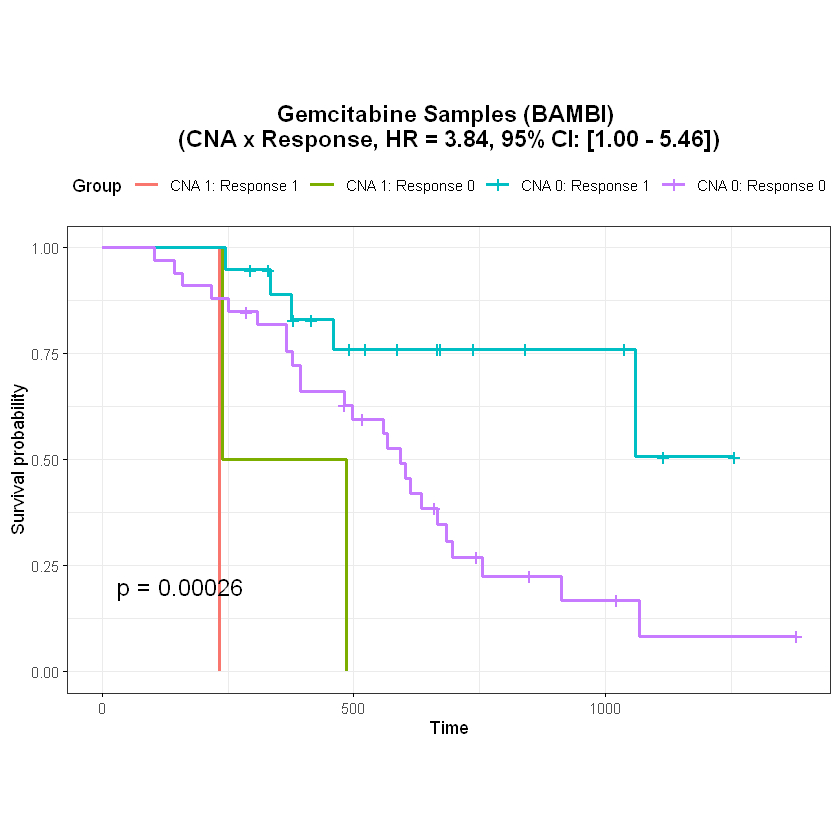

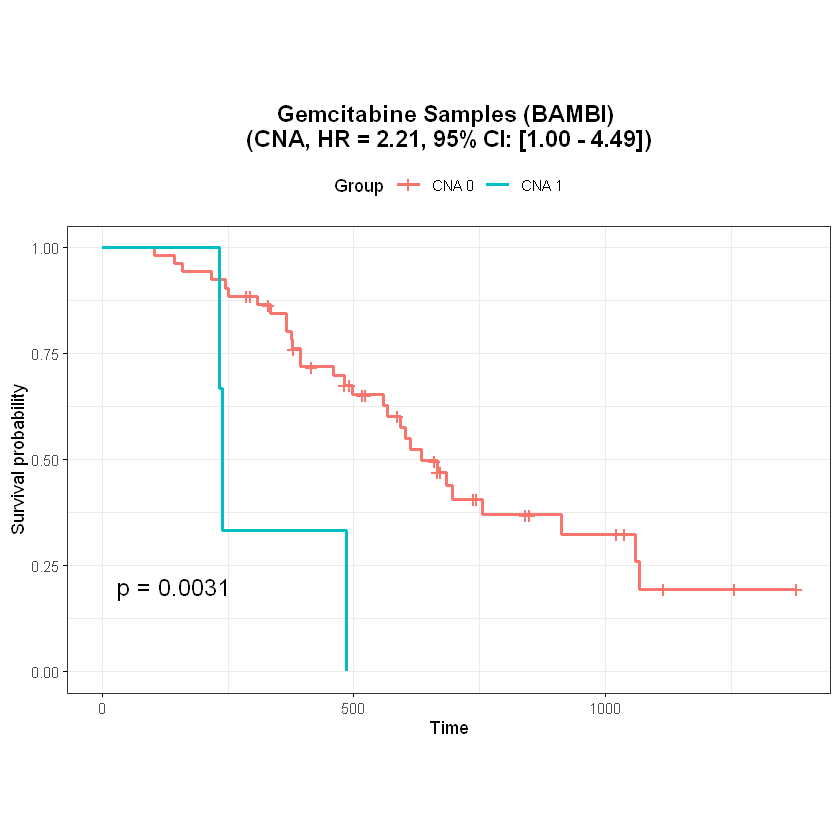

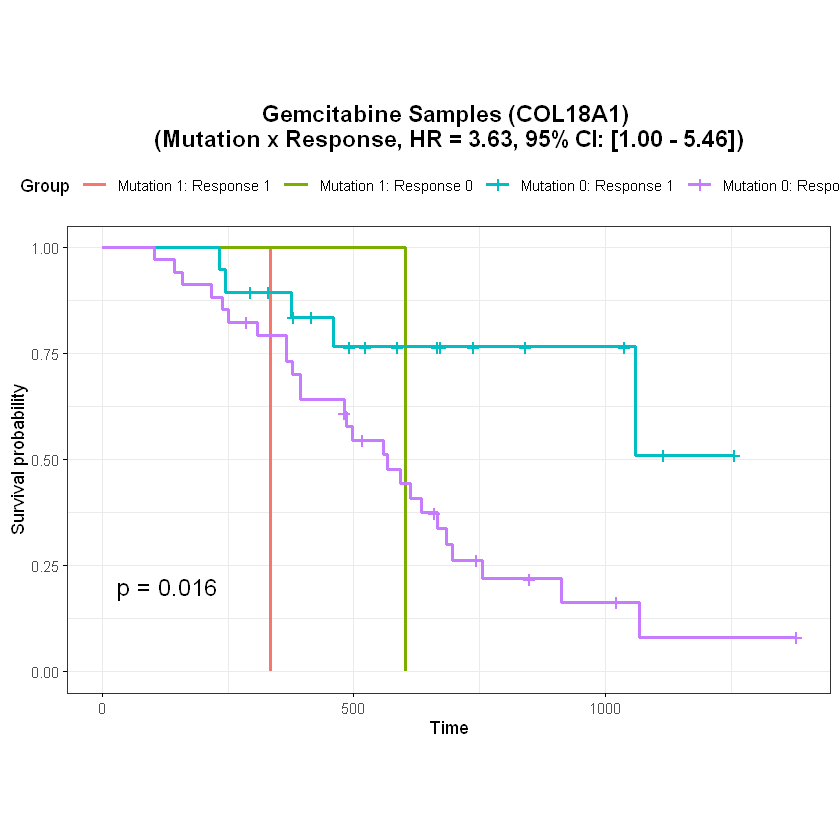

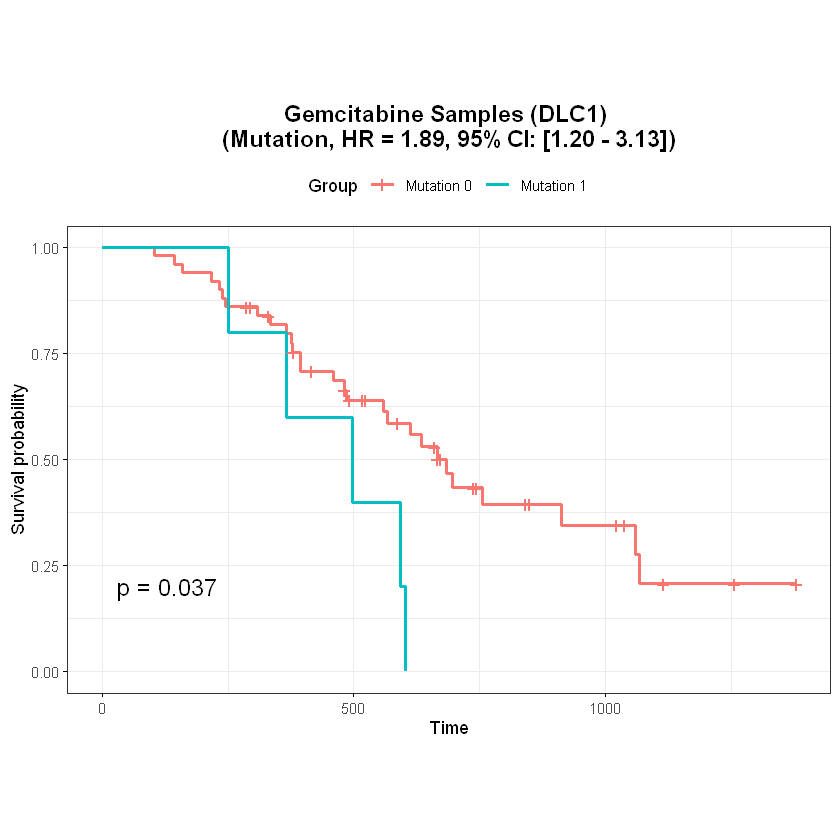

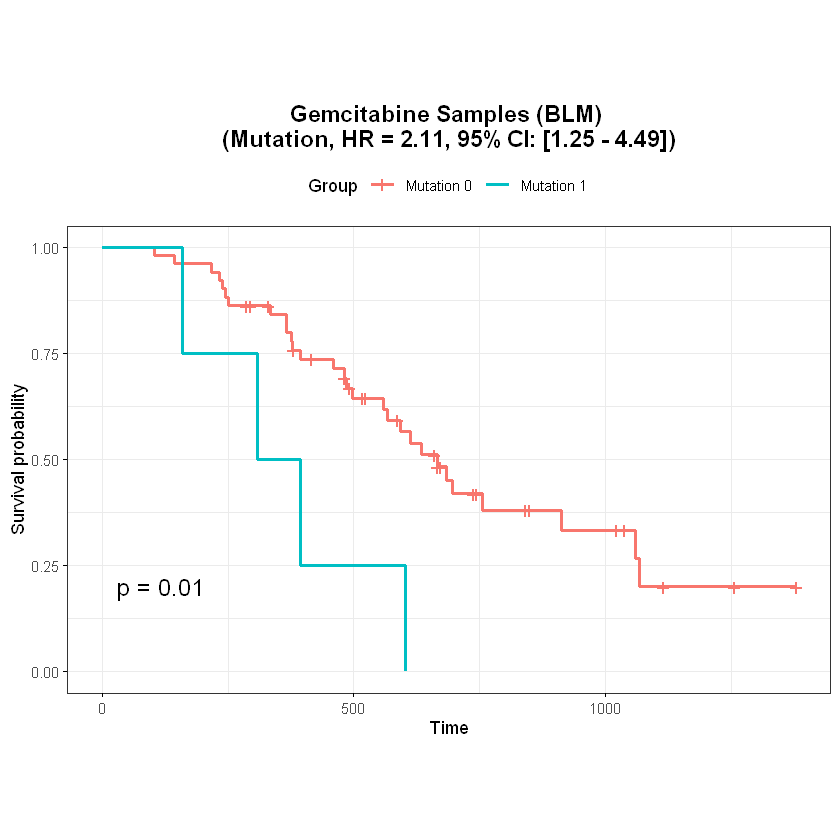

In [7]:
BAMBI
BAMBI_CNA
COL18A1
DLC1
BLM